## Dataset preparation from online

In [37]:
from google_images_download import google_images_download
import os
original_path = os.getcwd()
data_path = os.path.join(original_path,'downloads')

In [38]:
response = google_images_download.googleimagesdownload()
search_queries = ['smiling dogs','sad dogs']
## add smiling person as label 0

In [39]:
# m_smiling_dog = 1000
# m_smiling_person = 600
# m_sad_dog = 600
def downloadimages(query):
    arguments = dict(keywords=query,
                    limit=50,
                    format='jpg',
                    #aspect_ratio='wide',
                    #size='medium',
                    silent_mode=True)
    try: 
        response.download(arguments)     
    except FileNotFoundError:  
        arguments = dict(keywords=query,
                    limit=20,
                    format='jpg',
                    print_urls=True)                       
        try:  
            response.download(arguments)  
        except: 
            pass

In [40]:
download_msg = []
for query in search_queries: 
    downloadimages(query)
    msg = 'Downloaded {} {} images!'.format(len(os.listdir(os.path.join(data_path,query))),query)
    download_msg.append(msg)
for msg in download_msg:
    print(msg)

Downloaded 50 smiling dogs images!
Downloaded 50 sad dogs images!


## File renaming

In [45]:
data_folders = os.listdir(data_path)
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for i in range(len(os.listdir(working_dir))):
        original_name = current_list[i]
        new_name = "".join(folder.split()) + '_{:04d}'.format(i+1) + os.path.splitext(original_name)[-1]
        if not os.path.exists(new_name):
            os.rename(original_name,new_name)
os.chdir(original_path)

## display

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

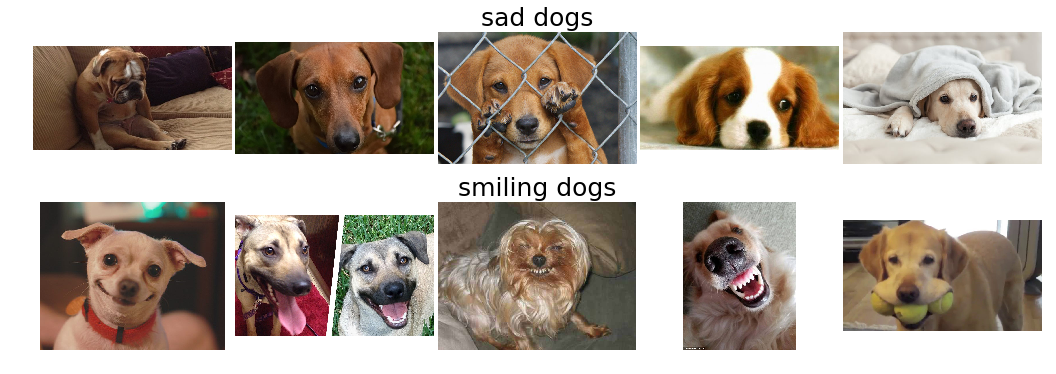

In [48]:
np.random.seed(seed=0)
n_samples = 5
fig, row = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))

for col,folder in zip(row,data_folders):
    col[int(np.floor(n_samples/2))].set_title(folder,fontsize=25)
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    for col_ax,img in zip(col,np.random.choice(os.listdir(os.getcwd()),n_samples,replace=False)):
        rand_img = cv2.imread(img)
        rand_img = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
        col_ax.imshow(rand_img)
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.02)
os.chdir(original_path)

## Load and pre-processing

In [49]:
img_rows = 128
img_cols = 128
img_list = []
label_list = []
labels = dict([('sad dogs',0),('smiling dogs',1)])
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for img in current_list:
        img_in = cv2.imread(img)
        img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2GRAY)
        img_in = cv2.resize(img_in,(img_rows,img_cols))
        img_list.append(img_in)
        label_list.append(labels[folder])
os.chdir(original_path)

#### normalization

In [50]:
img_data = np.array(img_list).astype('float32')
img_label = np.array(label_list)
img_data /= 255
img_data = np.expand_dims(img_data,axis=3)

In [51]:
print(img_data.shape) #(m,row,col,channel)
print(img_label.shape)

(100, 128, 128, 1)
(100,)


## Splitting

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_shuffled, y_shuffled = shuffle(img_data,img_label,random_state=0)

X_train,X_valid_test,y_train,y_valid_test = train_test_split(X_shuffled,y_shuffled,test_size=0.1,random_state=0,stratify=y_shuffled)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (90, 128, 128, 1)
y_train shape: (90,)
X_valid shape: (5, 128, 128, 1)
y_valid shape: (5,)
X_test shape: (5, 128, 128, 1)
y_test shape: (5,)


## Model building

In [54]:
from keras.models import Sequential
from keras.layers import Dense,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,ZeroPadding2D,GlobalAveragePooling2D,Dropout
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam,RMSprop
#from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.vgg16 import VGG16
#from keras import backend as K
#from keras.models import load_model

Using TensorFlow backend.


In [55]:
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=10**-8, amsgrad=False)
epochs = 20
batch_size = 32

In [56]:
X_input_shape = img_data[0].shape

model = Sequential([
    Conv2D(32,(3,3),padding='same',input_shape=X_input_shape),
    Activation('relu'),
    Conv2D(64,(3,3),padding='same',input_shape=X_input_shape),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
__________

In [58]:
hist = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=(X_valid,y_valid))#,callbacks=[save_best_model_1,learning_rate_reduction])

Train on 90 samples, validate on 5 samples
Epoch 1/20
90/90 [==============================] - 74s 827ms/step - loss: 3.1967 - acc: 0.4667 - val_loss: 7.8911 - val_acc: 0.4000
Epoch 2/20
90/90 [==============================] - 0s 3ms/step - loss: 3.9791 - acc: 0.4111 - val_loss: 1.2979 - val_acc: 0.6000
Epoch 3/20
90/90 [==============================] - 0s 3ms/step - loss: 1.3780 - acc: 0.5000 - val_loss: 0.7025 - val_acc: 0.6000
Epoch 4/20
90/90 [==============================] - 0s 3ms/step - loss: 0.7083 - acc: 0.6111 - val_loss: 0.6873 - val_acc: 0.4000
Epoch 5/20
90/90 [==============================] - 0s 3ms/step - loss: 0.6523 - acc: 0.7111 - val_loss: 0.6984 - val_acc: 0.4000
Epoch 6/20
90/90 [==============================] - 0s 3ms/step - loss: 0.6438 - acc: 0.6889 - val_loss: 0.7144 - val_acc: 0.4000
Epoch 7/20
90/90 [==============================] - 0s 3ms/step - loss: 0.6535 - acc: 0.6778 - val_loss: 0.7208 - val_acc: 0.6000
Epoch 8/20
90/90 [==========================

In [145]:
def training_plot(hist):
    loss = [hist.history['loss'],hist.history['val_loss']]
    acc = [hist.history['acc'],hist.history['val_acc']]
    
    fig, axes = plt.subplots(1,2,figsize = (15,3))
    for ax,val,name in zip(axes,(loss,acc),['loss','accuracy']):
        ax.plot(val[0], color='b', label="Training")
        ax.plot(val[1], color='r', label="Validation")
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)


def confusion_matrix_plot(y_true,y_pred,model_name):
    
    confusion_mtx = confusion_matrix(y_true,y_pred)
    confusion_mtx_normalized = confusion_mtx/confusion_mtx.sum(axis=1)

    plt.figure(figsize=(8,4))
    sns.heatmap(confusion_mtx,annot=True,cmap='coolwarm',fmt='d')
    plt.title('confusion matrix of '+ model_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    plt.figure(figsize=(8,4))
    sns.heatmap(confusion_mtx_normalized,annot=True,cmap='coolwarm')
    plt.title('Normalized confusion matrix of '+ model_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    plt.figure()
    plt.title('Correct prediction rate (%) of ' + model_name)
    sns.barplot(np.arange(len(np.unique(y_true))),np.diag(confusion_mtx_normalized)*100)
    plt.xlabel('Classes')

In [146]:
valid_loss, valid_accuracy = model.evaluate(X_valid, y_valid, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Dev: accuracy = %f  ;  loss = %f" % (valid_accuracy, valid_loss))
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

5/5 [==============================] - 0s 1ms/step
Dev: accuracy = 0.800000  ;  loss = 0.840393
Test: accuracy = 0.800000  ;  loss = 0.470190


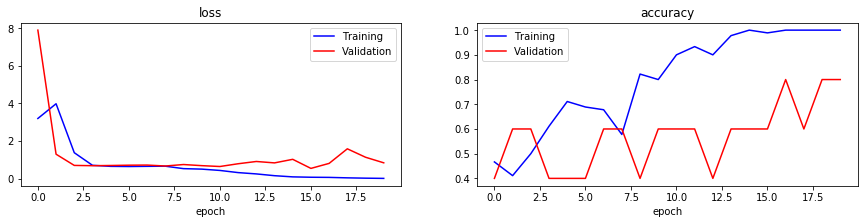

In [147]:
training_plot(hist)

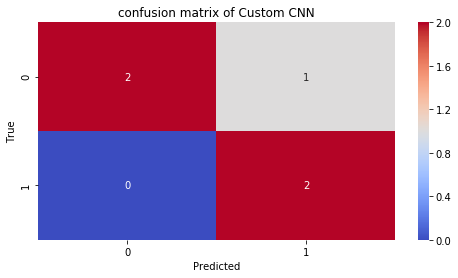

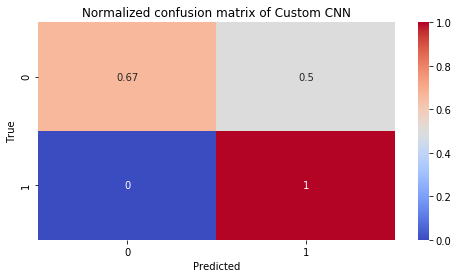

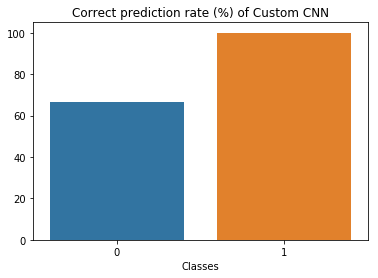

In [148]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
y_true = y_test
confusion_matrix_plot(y_true,y_pred,'Custom CNN')

In [ ]:

# test_image = cv2.imread('HAM10000_images_part_2/'+new_test_image_id+'.jpg')
# test_image = cv2.resize(test_image,(img_cols,img_rows))
# test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
# test_image_original = test_image.copy()
# test_image_flat = test_image.flatten()
# test_image_flat = scale(test_image_flat)
# test_image =test_image_flat.reshape(1,img_rows,img_cols,img_channels)

# plt.imshow(test_image_original)
# plt.axis('off')
# plt.title('example test image - cell_type_idx: '+str(true_cell_type_idx))
# plt.show()

# test_image_pred = model_2.predict(test_image)
# test_image_pred_classes = np.argmax(test_image_pred,axis=1)
# print('true cell_type_idx: {}'.format(true_cell_type_idx))
# print('predicted cell_type_idx: {}'.format(test_image_pred_classes[0]))

## make the notebook using image generator